We begin with a simple simulated example in which there truly are two clusters in the data: the first 25 observations have a mean shift relative to the next 25 observations.

Text(0, 0.5, 'X1')

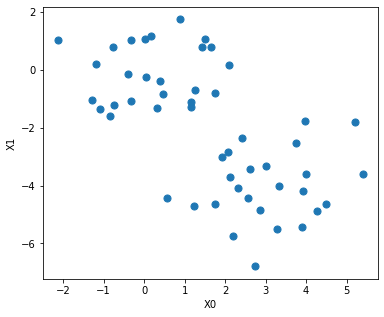

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(123)
X = np.random.randn(50,2)
X[0:25, 0] = X[0:25, 0] + 3
X[0:25, 1] = X[0:25, 1] - 4

f, ax = plt.subplots(figsize=(6, 5))
ax.scatter(X[:,0], X[:,1], s=50) 
ax.set_xlabel('X0')
ax.set_ylabel('X1')

# Hierarchical Clustering
The `linkage()` function from `scipy` implements several clustering functions in python. In the following example we use the data from the previous section to plot the hierarchical
clustering dendrogram using complete, single, and average linkage clustering,
with Euclidean distance as the dissimilarity measure. We begin by
clustering observations using complete linkage:

In [2]:
from scipy.cluster.hierarchy import linkage

hc_complete = linkage(X, "complete")

We could just as easily perform hierarchical clustering with average or single linkage instead:

In [3]:
hc_average = linkage(X, "average")
hc_single = linkage(X, "single")

We can now plot the dendrograms obtained using the usual `dendrogram()` function.
The numbers at the bottom of the plot identify each observation:

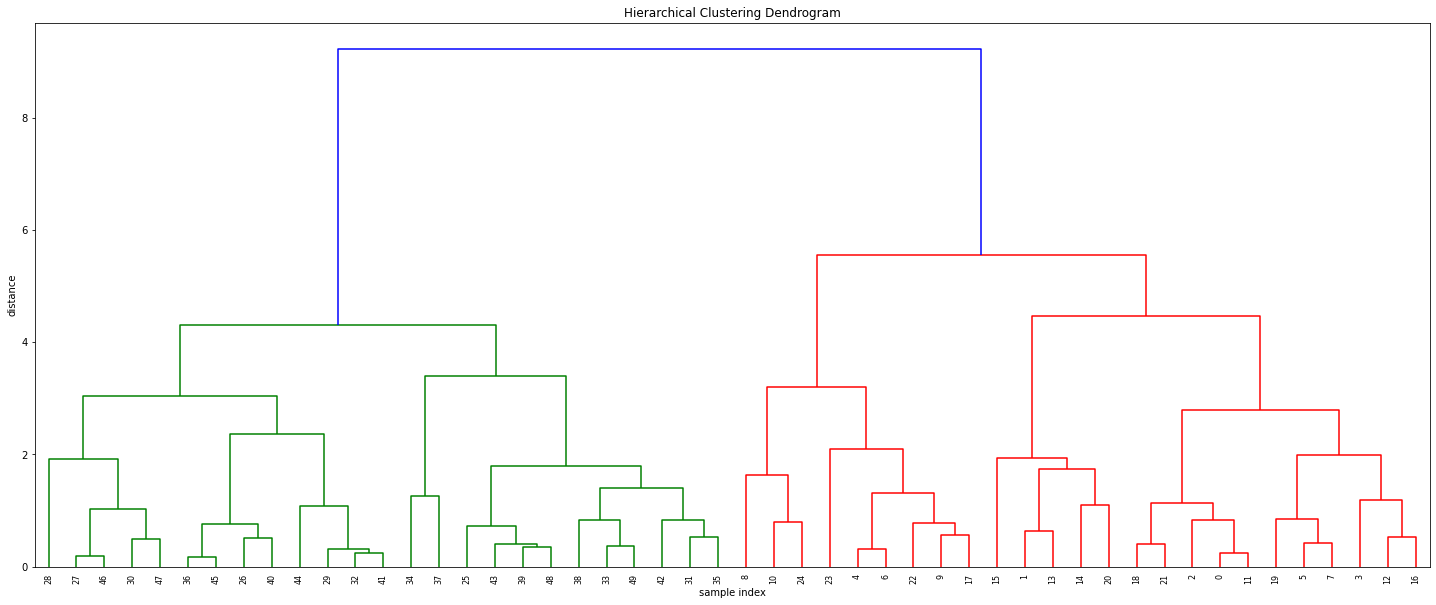

In [4]:
from scipy.cluster.hierarchy import dendrogram

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    hc_complete,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

To determine the cluster labels for each observation associated with a
given cut of the dendrogram, we can use the `cut_tree()` function:

In [5]:
from scipy.cluster.hierarchy import cut_tree
print(cut_tree(hc_complete, n_clusters = 2).T) # Printing transpose just for space

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


For this data, complete and average linkage generally separates the observations
into their correct groups.

# Sklearn implementation
This example plots the corresponding dendrogram of a hierarchical clustering using AgglomerativeClustering and the dendrogram method available in scipy.

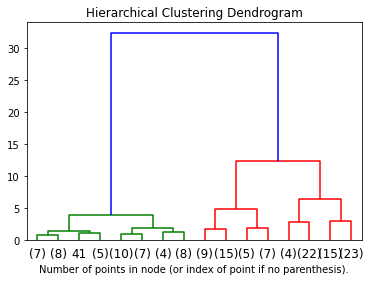

In [6]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Comparing different hierarchical linkage methods on toy datasets
This example shows characteristics of different linkage methods for hierarchical clustering on datasets that are “interesting” but still in 2D.

The main observations to make are:
* single linkage is fast, and can perform well on non-globular data, but it performs poorly in the presence of noise.

* average and complete linkage perform well on cleanly separated globular clusters, but have mixed results otherwise.

* Ward is the most effective method for noisy data.

While these examples give some intuition about the algorithms, this intuition might not apply to very high dimensional data.

In [7]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

Generate datasets. We choose the size big enough to see the scalability of the algorithms, but not too big to avoid too long running times

In [8]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

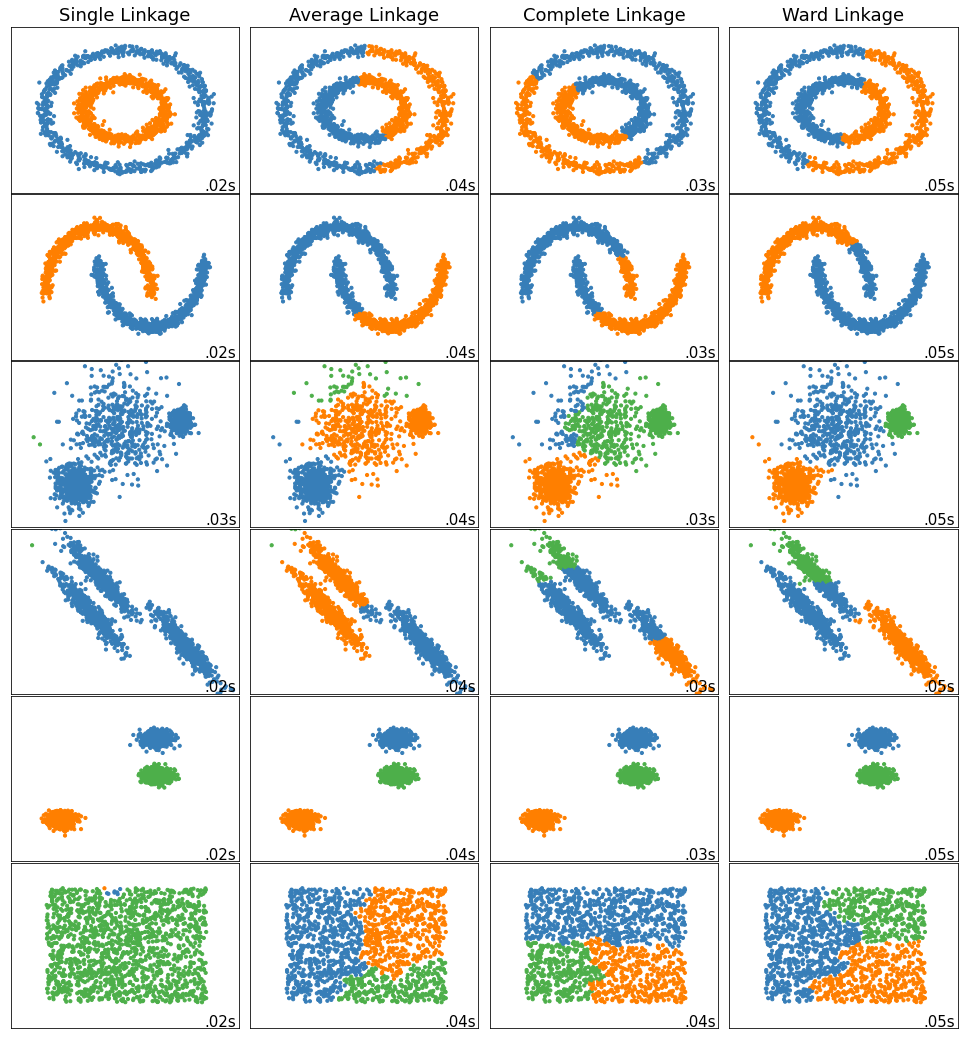

In [9]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'n_neighbors': 2}),
    (aniso, {'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


# Comparing different clustering algorithms on toy datasets
This example shows characteristics of different clustering algorithms on datasets that are “interesting” but still in 2D. With the exception of the last dataset, the parameters of each of these dataset-algorithm pairs has been tuned to produce good clustering results. Some algorithms are more sensitive to parameter values than others.

The last dataset is an example of a ‘null’ situation for clustering: the data is homogeneous, and there is no good clustering. For this example, the null dataset uses the same parameters as the dataset in the row above it, which represents a mismatch in the parameter values and the data structure.

While these examples give some intuition about the algorithms, this intuition might not apply to very high dimensional data.

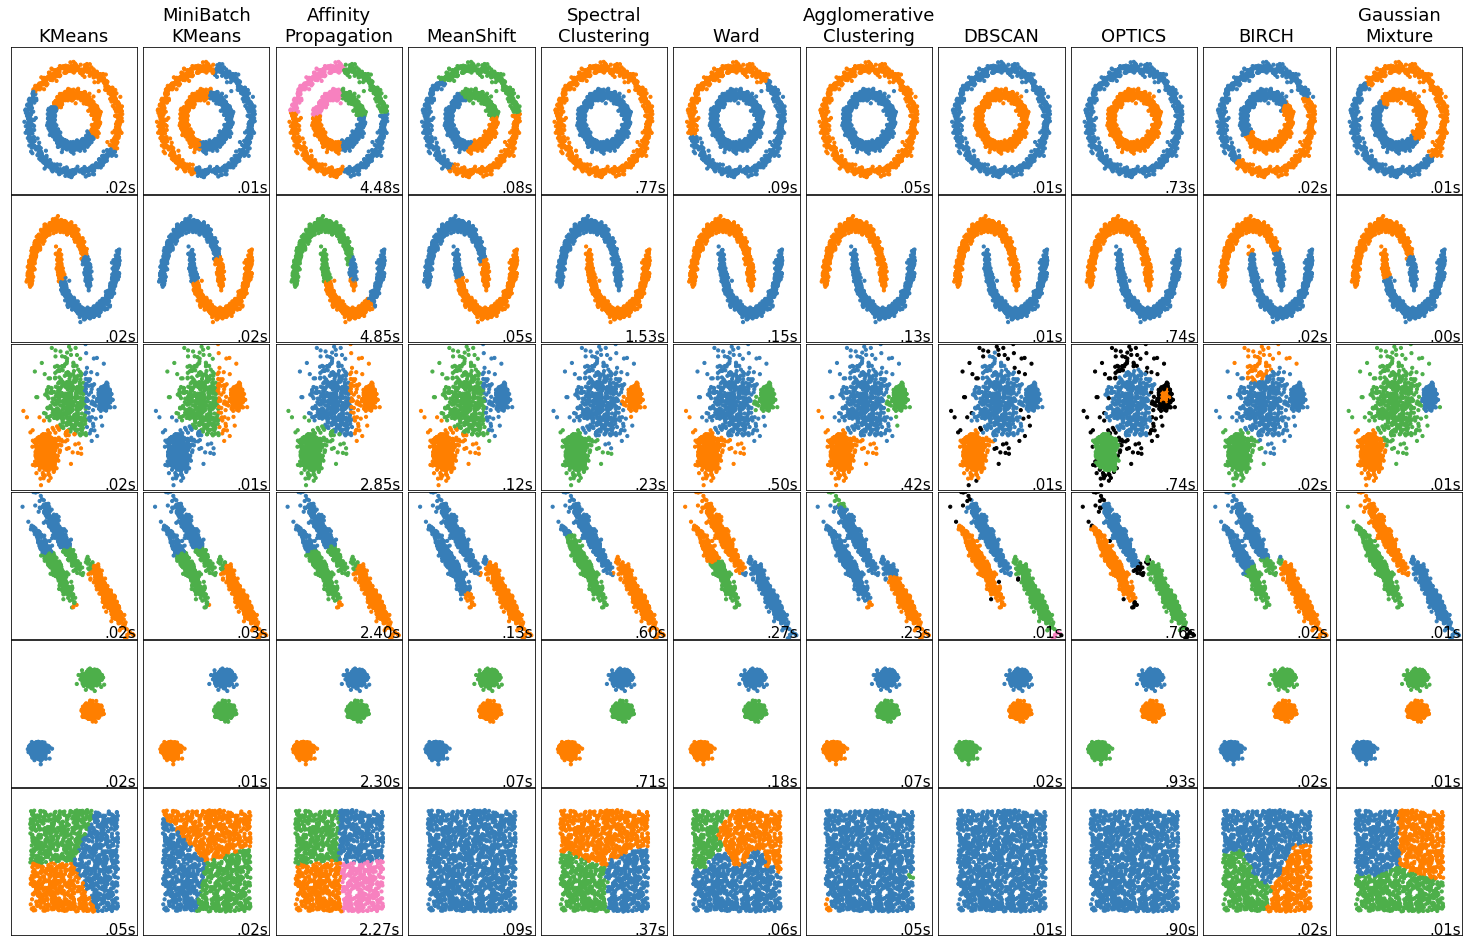

In [3]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('KMeans', kmeans),
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# NCI60 Data Example

Unsupervised techniques are often used in the analysis of genomic data. In this portion of the lab, we'll see how hierarchical and K-means clustering compare on the `NCI60` cancer cell line microarray data, which
consists of 6,830 gene expression measurements on 64 cancer cell lines:

In [10]:
# The NCI60 data
nci_labs = pd.read_csv("https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/nci60_labs.csv", index_col = 0)
nci_data = pd.read_csv("https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/nci60_data.csv", index_col = 0)

Each cell line is labeled with a cancer type. We'll ignore the
cancer types in performing clustering, as these are unsupervised
techniques. After performing clustering, we'll use this column to see the extent to which these cancer types agree with the results of these
unsupervised techniques.

The data has 64 rows and 6,830 columns.

In [11]:
nci_data.shape

(64, 6830)

Let's take a look at the cancer types for the cell lines:

In [12]:
nci_labs.x.value_counts(sort=True)

RENAL          9
NSCLC          9
MELANOMA       8
BREAST         7
COLON          7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
UNKNOWN        1
MCF7A-repro    1
K562B-repro    1
K562A-repro    1
MCF7D-repro    1
Name: x, dtype: int64

# Clustering the Observations of the NCI60 Data
We now proceed to hierarchically cluster the cell lines in the `NCI60` data,
with the goal of finding out whether or not the observations cluster into
distinct types of cancer.

We now perform hierarchical clustering of the observations using complete,
single, and average linkage. We'll use standard Euclidean distance as the dissimilarity
measure:

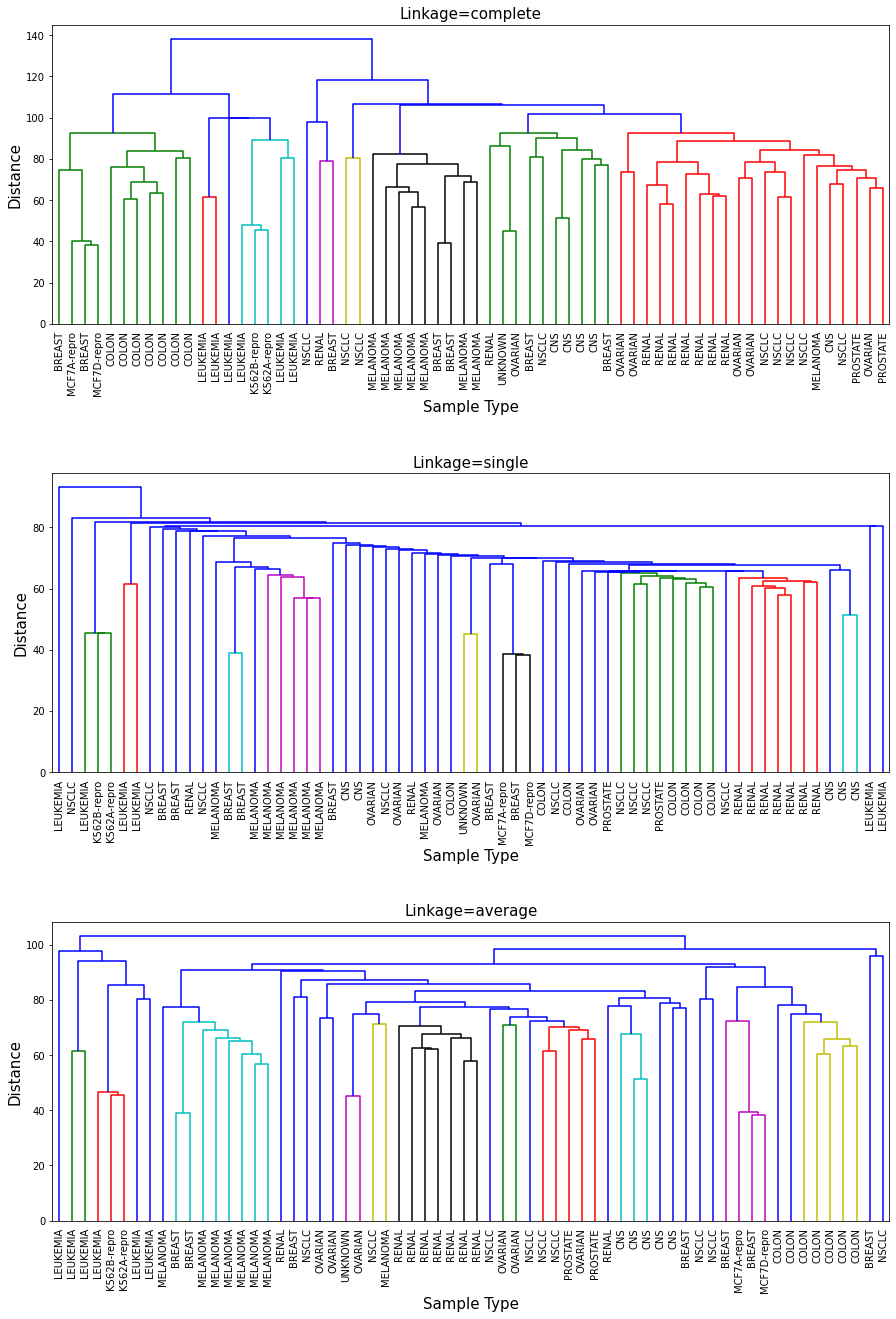

In [13]:
nci_data.index = nci_labs.x

fig, ax = plt.subplots(3,1, figsize=(15,22))
fig.subplots_adjust(hspace=0.5)

linkages = ['complete', 'single', 'average']
for link, axis in zip(linkages, fig.axes):
    hc = linkage(y = nci_data, method=link, metric='euclidean') 
    axis.set_title("Linkage=%s" % link, size=15)
    axis.set_xlabel('Sample Type', size=15)
    axis.set_ylabel('Distance', size=15)
    dendrogram(hc, ax=axis, labels=nci_data.index, leaf_rotation=90, leaf_font_size=10)

We see that the choice of linkage
certainly does affect the results obtained. Typically, single linkage will tend
to yield trailing clusters: very large clusters onto which individual observations
attach one-by-one. On the other hand, complete and average linkage
tend to yield more balanced, attractive clusters. For this reason, complete
and average linkage are generally preferred to single linkage. Clearly cell
lines within a single cancer type do tend to cluster together, although the
clustering is not perfect. 

Let's use our complete linkage hierarchical clustering
for the analysis. We can cut the dendrogram at the height that will yield a particular
number of clusters, say 4:

In [14]:
nci_hc_complete = linkage(y = nci_data, method="complete", metric='euclidean') 

nci_hc_complete_4_clusters = cut_tree(nci_hc_complete, n_clusters =4) # Printing transpose just for space

pd.crosstab(index = nci_data.index, 
            columns = nci_hc_complete_4_clusters.T[0], 
            rownames = ['Cancer Type'], 
            colnames = ['Cluster'])

Cluster,0,1,2,3
Cancer Type,,,,
BREAST,4,1,0,2
CNS,5,0,0,0
COLON,0,0,0,7
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,0,0,6,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,8,0,0,0


There are some clear patterns. All the leukemia cell lines fall in cluster 2,
while the breast cancer cell lines are spread out over three different clusters.
We can plot the cut on the dendrogram that produces these four clusters by adding an `axhline()`, which draws a horizontal line on top of our plot:

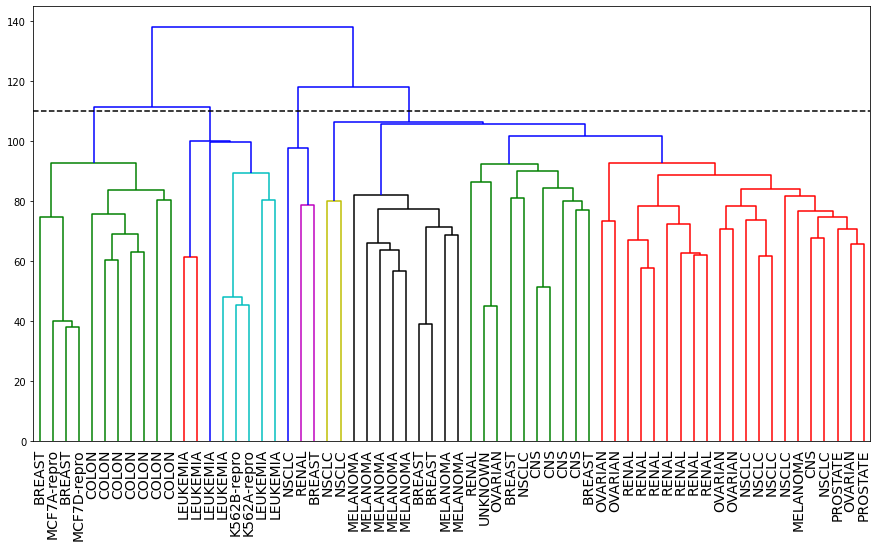

In [15]:
fig, ax = plt.subplots(1,1, figsize = (15,8))
dendrogram(nci_hc_complete, 
           labels = nci_data.index, 
           leaf_font_size = 14, 
           show_leaf_counts = True)  

plt.axhline(y=110, c='k', ls='dashed')
plt.show()

We claimed earlier that K-means clustering and hierarchical
clustering with the dendrogram cut to obtain the same number
of clusters can yield **very** different results. How do these `NCI60` hierarchical
clustering results compare to what we get if we perform K-means clustering
with `K = 4`?

In [16]:
from sklearn.cluster import KMeans
kmean_4 = KMeans(n_clusters = 4, random_state = 123, n_init = 150)    
kmean_4.fit(nci_data)
kmean_4.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int32)

We can use a confusion matrix to compare the differences in how the two methods assigned observations to clusters:

In [17]:
pd.crosstab(index = kmean_4.labels_, 
            columns = nci_hc_complete_4_clusters.T[0], 
            rownames = ['K-Means'], 
            colnames = ['Hierarchical'])

Hierarchical,0,1,2,3
K-Means,,,,
0,8,0,0,11
1,0,0,8,0
2,25,3,0,0
3,9,0,0,0


We see that the four clusters obtained using hierarchical clustering and Kmeans
clustering are somewhat different. Cluster 0 in K-means clustering is almost
identical to cluster 2 in hierarchical clustering. However, the other clusters
differ: for instance, cluster 2 in K-means clustering contains a portion of
the observations assigned to cluster 0 by hierarchical clustering, as well as
all of the observations assigned to cluster 1 by hierarchical clustering.

To get credit for this lab, use a similar analysis to compare the results of your K-means clustering to the results of your hierarchical clustering with single and average linkage. What differences do you notice? 